# Partial re-implementation of [Prior-aware autoencoders for lung pathology segmentation](https://www.sciencedirect.com/science/article/pii/S1361841522001384)

This paper is made up by 3 models:

1. a Partial Convolutionl Neural Network (PCNN) written as an autoencoder
2. a Normal Appearance Autoencoder model (NAA)
3. the Prior UNet which predicts the lung pathology segmentation mask.

This notebook will implement 2 and 3 the same way as the paper, but will the [Semantic Diffusion Model](https://github.com/WeilunWang/semantic-diffusion-model) instead for 1.

In [9]:
!pip install torch numpy Pillow torchsummary torchvision matplotlib


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [10]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import numpy as np
import os
from PIL import Image
import tqdm
import torch.nn.functional as F

## Module 1: Semantic Diffusion Model

The diffusion model has been trained and should be able to perform inference using the /scripts/luna16.sh script in the SDM folder.
Here, we only prepare the dataset that can be used to train the NAA model.

In [11]:
# Directly inference from the trained SDM model to generate pathlogy free images
# by running the /scripts/luna16.sh under the Semantic Diffusion Model directory

# Prepare training and test dataset
LESION_PATH = "/home/user/data/prior_train/gt/"
# LESION_FREE_PATH = "/home/user/data/prior_train/lesion-free"
LESION_FREE_PATH = "/home/user/data/prior_train/inpainted/"
WEIGHT_MAP_PATH = "/home/user/luna-16-seg-diff-data/nodule_labels_ohe/"

class NAAImageDataset(Dataset):
  def __init__(self, lesion_path, lesion_free_path, weight_map_path):
    self.lesion_path = lesion_path
    self.lesion_free_path = lesion_free_path
    self.weight_map_path = weight_map_path
    self.file_list = os.listdir(self.lesion_path)
  
  def __len__(self):
    return len(self.file_list)
  
  def __getitem__(self, idx):
    filename = self.file_list[idx]
    lesion_image = Image.open(os.path.join(self.lesion_path, filename))
    lesion_free_image = Image.open(os.path.join(self.lesion_free_path, filename))
    
    lesion_image = lesion_image.convert('L')
    lesion_free_image = lesion_free_image.convert('L')
    
    weight_map = Image.open(os.path.join(self.weight_map_path, filename[:-4]))
    weight_map = weight_map.resize((256, 256))
    weight_map = weight_map.convert('L')
    # Convert the grayscale image to a NumPy array
    grayscale_array = np.array(weight_map)
    mask = grayscale_array > 0
    converted_array = np.where(mask, 2, 0)
    
    # Create a new image from the converted array
    # converted_image = Image.fromarray(converted_array.astype(np.uint8))
    
    return transforms.ToTensor()(lesion_image), transforms.ToTensor()(lesion_free_image), transforms.ToTensor()(converted_array)

In [12]:
dataset = NAAImageDataset(LESION_PATH, LESION_FREE_PATH, WEIGHT_MAP_PATH)

# randomly split dataset into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# create dataloaders for train and test sets
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

## Module 2: Normal Appearance Autoencoder

In [13]:
# Define the Normal Apperance Autoencoder (NAA). It consists of an input layer of size 512, 5 hidden layers of size 256, 128, 64, 64, 64 and a sampling layer for mean and logvar of size 64
# Define a convolution layer where each conv block consists of a conv2d layer, a batchnorm layer, then another conv2d layer followed by another batch normalization layer and finally a relu layer
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True, max_pool=True):
        super(ConvBlock, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding, bias=bias),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.maxpool = nn.MaxPool2d(2) if max_pool else None
        self.dropout = nn.Dropout(0.2)
    def forward(self, x):
        x = self.layers(x)
        if self.maxpool is not None:
            x = self.maxpool(x)
        x = self.dropout(x)
        return x


class NAA(nn.Module):
    def __init__(self):
        super(NAA, self).__init__()
        self.encoder = torch.nn.Sequential(
            ConvBlock(1, 8, kernel_size=3),
            ConvBlock(8, 16, kernel_size=3),
            ConvBlock(16, 32, kernel_size=3, max_pool=False),
            ConvBlock(32, 64, kernel_size=3, max_pool=False),
            ConvBlock(64, 128, kernel_size=3, max_pool=False),
        )
        self.mean = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.logvar = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.mean_relu = nn.ReLU()
        self.logvar_relu = nn.ReLU()
        
        # few layers are commented out for experimental reasons
        self.decoder = torch.nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            # nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # nn.Dropout(0.2),
            ConvBlock(128, 64, kernel_size=3, max_pool=False),
            nn.Upsample(scale_factor=2, mode='nearest'),
            # nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # nn.Dropout(0.2),
            ConvBlock(64, 32, kernel_size=3, max_pool=False),
            # nn.Upsample(scale_factor=2, mode='nearest'),
            # nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # nn.Dropout(0.2),
            ConvBlock(32, 16, kernel_size=3, max_pool=False),
            # nn.Upsample(scale_factor=2, mode='nearest'),
            # nn.ConvTranspose2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # nn.Dropout(0.2),
            ConvBlock(16, 8, kernel_size=3, max_pool=False),
            # nn.Upsample(scale_factor=2, mode='nearest'),
            # nn.ConvTranspose2d(8, 1, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # nn.Dropout(0.2),
            nn.Conv2d(8, 1, kernel_size=1),
            # nn.Sigmoid()
        )

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std
        
    def encode(self, x):
        return self.encoder(x)

    def forward(self, x):
        x = self.encoder(x)
        mean = self.mean(x)
        logvar = self.logvar(x)
        z = self.reparameterize(self.mean_relu(mean), self.logvar_relu(logvar))
        x = self.decoder(z)
        return x, mean, logvar

In [14]:
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NAA().to(device)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
summary(model, input_size=(1, 256, 256))

import gc
model = model.cpu()
del model
gc.collect()
torch.cuda.empty_cache()

Total number of parameters is: 738673
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 256, 256]              80
       BatchNorm2d-2          [-1, 8, 256, 256]              16
            Conv2d-3          [-1, 8, 256, 256]             584
       BatchNorm2d-4          [-1, 8, 256, 256]              16
              ReLU-5          [-1, 8, 256, 256]               0
         MaxPool2d-6          [-1, 8, 128, 128]               0
           Dropout-7          [-1, 8, 128, 128]               0
         ConvBlock-8          [-1, 8, 128, 128]               0
            Conv2d-9         [-1, 16, 128, 128]           1,168
      BatchNorm2d-10         [-1, 16, 128, 128]              32
           Conv2d-11         [-1, 16, 128, 128]           2,320
      BatchNorm2d-12         [-1, 16, 128, 128]              32
             ReLU-13         [-1, 16, 128, 128]               0
 

In [15]:
from torch.optim.lr_scheduler import LinearLR, ExponentialLR

model = NAA().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = ExponentialLR(optimizer, gamma=0.85)
num_epochs = 40

def loss_function(recon_x, input, target, mu, logvar, weight_map):  
  alpha = 0.001 # as suggested by the paper
  REC = F.mse_loss(recon_x, target, reduction='none') * weight_map
  REC = 5 * REC.view(REC.size(0), -1).sum(1)
  REG = alpha * F.mse_loss(model.encode(input), model.encode(target), reduction='none')
  REG = REG.view(REG.size(0), -1).sum(1)
  KLD = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp())
  KLD = KLD.view(KLD.size(0), -1).sum(1)
  
  # print(REC.shape, REG.shape, KLD.shape)

  return (REC + REG + KLD).mean(), REC.mean(), REG.mean(), KLD.mean()

print("Training begins!")

for epoch in range(num_epochs):
  model.train()
  print(f"Epoch {epoch} begins:")
  with tqdm.tqdm(train_dataloader, unit="batch") as tepoch:
    for batch_idx, (lesion, lesion_free, weight_map) in enumerate(tepoch):
      lesion = lesion.to(device)
      lesion_free = lesion_free.to(device)
      weight_map = weight_map.to(device)
      optimizer.zero_grad()
      recon, mu, logvar = model(lesion)
      # print(model.parameters())
      # print(recon.shape)
      # print(mu.shape)
      # print(logvar.shape)
      loss, rec, reg, kld = loss_function(recon, lesion, lesion_free, mu, logvar, weight_map)
      loss.backward()
      optimizer.step()
      
      if batch_idx % 20 == 0:
        tepoch.set_description(f"Epoch {epoch} / {num_epochs}, batch {batch_idx}, Loss: {loss / len(lesion)}, REC: {rec / len(lesion)}, REG: {reg / len(lesion)}, KLD: {kld / len(lesion)}")
        tepoch.set_postfix(loss=loss.item()/len(lesion))
    scheduler.step()

  model.eval()
  
  with torch.no_grad():
    with tqdm.tqdm(test_dataloader, unit="batch") as tepoch:
      for batch_idx, (lesion, lesion_free, weight_map) in enumerate(tepoch):
        lesion = lesion.to(device)
        lesion_free = lesion_free.to(device)
        weight_map = weight_map.to(device)
        recon, mu, logvar = model(lesion)
        loss, rec, reg, kld = loss_function(recon, lesion, lesion_free, mu, logvar, weight_map)
        if batch_idx % 20 == 0:
          tepoch.set_description(f"Validation loss: {loss / len(lesion)}, REC: {rec / len(lesion)}, REG: {reg / len(lesion)}, KLD: {kld / len(lesion)}")


Training begins!
Epoch 0 begins:


Epoch 0 / 40, batch 40, Loss: 159752.125, REC: 1469.25244140625, REG: 8.38845443725586, KLD: 158274.46875: 100%|██████████| 57/57 [00:14<00:00,  3.89batch/s, loss=1.6e+5]         
Validation loss: 144490.40625, REC: 954.5509643554688, REG: 0.014151559211313725, KLD: 143535.828125: 100%|██████████| 15/15 [00:02<00:00,  6.20batch/s]


Epoch 1 begins:


Epoch 1 / 40, batch 40, Loss: 120860.6875, REC: 1029.3355712890625, REG: 8.510164260864258, KLD: 119822.84375: 100%|██████████| 57/57 [00:07<00:00,  7.26batch/s, loss=1.21e+5] 
Validation loss: 121268.6875, REC: 920.544677734375, REG: 0.01409266609698534, KLD: 120348.125: 100%|██████████| 15/15 [00:01<00:00,  8.19batch/s]


Epoch 2 begins:


Epoch 2 / 40, batch 40, Loss: 108809.9140625, REC: 836.7703857421875, REG: 8.779557228088379, KLD: 107964.375: 100%|██████████| 57/57 [00:07<00:00,  7.37batch/s, loss=1.09e+5]   
Validation loss: 104603.3828125, REC: 716.6390380859375, REG: 0.01261083036661148, KLD: 103886.7265625: 100%|██████████| 15/15 [00:01<00:00,  8.26batch/s]


Epoch 3 begins:


Epoch 3 / 40, batch 40, Loss: 100043.8359375, REC: 975.9896240234375, REG: 8.495404243469238, KLD: 99059.359375: 100%|██████████| 57/57 [00:07<00:00,  7.31batch/s, loss=1e+5]   
Validation loss: 102486.46875, REC: 776.4620361328125, REG: 0.013054482638835907, KLD: 101709.984375: 100%|██████████| 15/15 [00:01<00:00,  8.25batch/s]


Epoch 4 begins:


Epoch 4 / 40, batch 40, Loss: 92945.46875, REC: 823.015869140625, REG: 8.397344589233398, KLD: 92114.0546875: 100%|██████████| 57/57 [00:07<00:00,  7.31batch/s, loss=9.29e+4] 
Validation loss: 96318.734375, REC: 747.8330078125, REG: 0.01445716805756092, KLD: 95570.8828125: 100%|██████████| 15/15 [00:01<00:00,  8.32batch/s]


Epoch 5 begins:


Epoch 5 / 40, batch 40, Loss: 91673.5703125, REC: 850.343994140625, REG: 9.046357154846191, KLD: 90814.171875: 100%|██████████| 57/57 [00:07<00:00,  7.38batch/s, loss=9.17e+4]
Validation loss: 90440.796875, REC: 749.2194213867188, REG: 0.02244015969336033, KLD: 89691.5625: 100%|██████████| 15/15 [00:01<00:00,  8.52batch/s]


Epoch 6 begins:


Epoch 6 / 40, batch 40, Loss: 86647.609375, REC: 778.0882568359375, REG: 8.895895957946777, KLD: 85860.625: 100%|██████████| 57/57 [00:07<00:00,  7.31batch/s, loss=8.66e+4]  
Validation loss: 91650.765625, REC: 716.482177734375, REG: 0.01810346357524395, KLD: 90934.265625: 100%|██████████| 15/15 [00:01<00:00,  8.64batch/s]


Epoch 7 begins:


Epoch 7 / 40, batch 40, Loss: 83879.296875, REC: 840.325439453125, REG: 8.68149185180664, KLD: 83030.2890625: 100%|██████████| 57/57 [00:07<00:00,  7.28batch/s, loss=8.39e+4]  
Validation loss: 88688.828125, REC: 787.9968872070312, REG: 0.019640877842903137, KLD: 87900.8125: 100%|██████████| 15/15 [00:01<00:00,  8.61batch/s]


Epoch 8 begins:


Epoch 8 / 40, batch 40, Loss: 81465.4375, REC: 736.3811645507812, REG: 8.744891166687012, KLD: 80720.3203125: 100%|██████████| 57/57 [00:07<00:00,  7.28batch/s, loss=8.15e+4]
Validation loss: 90977.96875, REC: 670.712890625, REG: 0.02251376584172249, KLD: 90307.234375: 100%|██████████| 15/15 [00:01<00:00,  8.58batch/s]


Epoch 9 begins:


Epoch 9 / 40, batch 40, Loss: 79296.1640625, REC: 961.732421875, REG: 8.87260627746582, KLD: 78325.5546875: 100%|██████████| 57/57 [00:07<00:00,  7.28batch/s, loss=7.93e+4]  
Validation loss: 84583.4140625, REC: 690.3926391601562, REG: 0.01037684641778469, KLD: 83893.015625: 100%|██████████| 15/15 [00:01<00:00,  8.58batch/s]


Epoch 10 begins:


Epoch 10 / 40, batch 40, Loss: 77640.546875, REC: 812.975341796875, REG: 8.785293579101562, KLD: 76818.78125: 100%|██████████| 57/57 [00:07<00:00,  7.14batch/s, loss=7.76e+4]  
Validation loss: 84845.296875, REC: 709.9344482421875, REG: 0.01227483805269003, KLD: 84135.34375: 100%|██████████| 15/15 [00:01<00:00,  8.48batch/s]


Epoch 11 begins:


Epoch 11 / 40, batch 40, Loss: 76754.4609375, REC: 870.76220703125, REG: 8.691119194030762, KLD: 75875.0078125: 100%|██████████| 57/57 [00:08<00:00,  6.98batch/s, loss=7.68e+4]
Validation loss: 82780.8359375, REC: 681.1070556640625, REG: 0.00815923698246479, KLD: 82099.7265625: 100%|██████████| 15/15 [00:01<00:00,  8.36batch/s]


Epoch 12 begins:


Epoch 12 / 40, batch 40, Loss: 74978.8359375, REC: 807.81787109375, REG: 8.902849197387695, KLD: 74162.125: 100%|██████████| 57/57 [00:08<00:00,  7.07batch/s, loss=7.5e+4]    
Validation loss: 85661.96875, REC: 719.646240234375, REG: 0.020505761727690697, KLD: 84942.3046875: 100%|██████████| 15/15 [00:01<00:00,  8.55batch/s]


Epoch 13 begins:


Epoch 13 / 40, batch 40, Loss: 73852.578125, REC: 812.6661987304688, REG: 8.767389297485352, KLD: 73031.140625: 100%|██████████| 57/57 [00:07<00:00,  7.20batch/s, loss=7.39e+4] 
Validation loss: 83973.71875, REC: 748.866455078125, REG: 0.0135565847158432, KLD: 83224.8359375: 100%|██████████| 15/15 [00:01<00:00,  8.60batch/s]


Epoch 14 begins:


Epoch 14 / 40, batch 40, Loss: 71858.875, REC: 731.1046142578125, REG: 8.767695426940918, KLD: 71119.0: 100%|██████████| 57/57 [00:08<00:00,  6.76batch/s, loss=7.19e+4]         
Validation loss: 77999.140625, REC: 833.1495361328125, REG: 0.015134667977690697, KLD: 77165.9765625: 100%|██████████| 15/15 [00:01<00:00,  7.74batch/s]


Epoch 15 begins:


Epoch 15 / 40, batch 40, Loss: 73036.765625, REC: 870.407958984375, REG: 8.729743003845215, KLD: 72157.6328125: 100%|██████████| 57/57 [00:08<00:00,  6.96batch/s, loss=7.3e+4]  
Validation loss: 80265.609375, REC: 733.8482666015625, REG: 0.011382298544049263, KLD: 79531.75: 100%|██████████| 15/15 [00:01<00:00,  8.60batch/s]


Epoch 16 begins:


Epoch 16 / 40, batch 40, Loss: 71607.6875, REC: 681.24755859375, REG: 9.09024429321289, KLD: 70917.359375: 100%|██████████| 57/57 [00:07<00:00,  7.19batch/s, loss=7.16e+4]    
Validation loss: 77670.1875, REC: 723.3248291015625, REG: 0.009225443936884403, KLD: 76946.859375: 100%|██████████| 15/15 [00:01<00:00,  8.16batch/s]


Epoch 17 begins:


Epoch 17 / 40, batch 40, Loss: 68225.9375, REC: 684.6696166992188, REG: 8.643209457397461, KLD: 67532.625: 100%|██████████| 57/57 [00:07<00:00,  7.23batch/s, loss=6.82e+4]     
Validation loss: 76241.453125, REC: 757.5885009765625, REG: 0.015496579930186272, KLD: 75483.859375: 100%|██████████| 15/15 [00:01<00:00,  8.59batch/s]


Epoch 18 begins:


Epoch 18 / 40, batch 40, Loss: 69221.5859375, REC: 721.8804931640625, REG: 8.525341033935547, KLD: 68491.1875: 100%|██████████| 57/57 [00:07<00:00,  7.27batch/s, loss=6.92e+4]  
Validation loss: 75943.8125, REC: 693.338134765625, REG: 0.014869083650410175, KLD: 75250.453125: 100%|██████████| 15/15 [00:01<00:00,  8.77batch/s]


Epoch 19 begins:


Epoch 19 / 40, batch 40, Loss: 70496.5078125, REC: 735.3092651367188, REG: 8.92529582977295, KLD: 69752.28125: 100%|██████████| 57/57 [00:08<00:00,  7.04batch/s, loss=7.05e+4]  
Validation loss: 76772.53125, REC: 706.988037109375, REG: 0.014674416743218899, KLD: 76065.53125: 100%|██████████| 15/15 [00:01<00:00,  8.48batch/s]


Epoch 20 begins:


Epoch 20 / 40, batch 40, Loss: 70040.53125, REC: 685.3519287109375, REG: 9.138355255126953, KLD: 69346.046875: 100%|██████████| 57/57 [00:07<00:00,  7.26batch/s, loss=7e+4]    
Validation loss: 76309.8125, REC: 773.1438598632812, REG: 0.015757650136947632, KLD: 75536.640625: 100%|██████████| 15/15 [00:01<00:00,  8.62batch/s]


Epoch 21 begins:


Epoch 21 / 40, batch 40, Loss: 67334.90625, REC: 797.7279052734375, REG: 8.46285629272461, KLD: 66528.71875: 100%|██████████| 57/57 [00:07<00:00,  7.30batch/s, loss=6.73e+4]
Validation loss: 74226.171875, REC: 677.99609375, REG: 0.027653157711029053, KLD: 73548.1484375: 100%|██████████| 15/15 [00:01<00:00,  8.60batch/s]


Epoch 22 begins:


Epoch 22 / 40, batch 40, Loss: 67490.7734375, REC: 746.4686889648438, REG: 8.523515701293945, KLD: 66735.78125: 100%|██████████| 57/57 [00:07<00:00,  7.27batch/s, loss=6.75e+4]
Validation loss: 74212.953125, REC: 758.695068359375, REG: 0.010651908814907074, KLD: 73454.25: 100%|██████████| 15/15 [00:01<00:00,  8.52batch/s]


Epoch 23 begins:


Epoch 23 / 40, batch 40, Loss: 68363.265625, REC: 820.1463623046875, REG: 8.945384979248047, KLD: 67534.1796875: 100%|██████████| 57/57 [00:07<00:00,  7.14batch/s, loss=6.84e+4]
Validation loss: 74973.6796875, REC: 658.0362548828125, REG: 0.014608320780098438, KLD: 74315.625: 100%|██████████| 15/15 [00:01<00:00,  8.40batch/s]


Epoch 24 begins:


Epoch 24 / 40, batch 40, Loss: 67654.2734375, REC: 741.2373046875, REG: 9.155136108398438, KLD: 66903.890625: 100%|██████████| 57/57 [00:07<00:00,  7.33batch/s, loss=6.77e+4]
Validation loss: 72830.9921875, REC: 725.26708984375, REG: 0.012678148224949837, KLD: 72105.703125: 100%|██████████| 15/15 [00:01<00:00,  8.50batch/s]


Epoch 25 begins:


Epoch 25 / 40, batch 40, Loss: 65835.5078125, REC: 866.2803955078125, REG: 8.537833213806152, KLD: 64960.6875: 100%|██████████| 57/57 [00:07<00:00,  7.29batch/s, loss=6.58e+4]
Validation loss: 72830.8125, REC: 730.912841796875, REG: 0.011800461448729038, KLD: 72099.875: 100%|██████████| 15/15 [00:01<00:00,  8.37batch/s]


Epoch 26 begins:


Epoch 26 / 40, batch 40, Loss: 66603.4375, REC: 720.156982421875, REG: 8.940814018249512, KLD: 65874.34375: 100%|██████████| 57/57 [00:08<00:00,  7.11batch/s, loss=6.66e+4]     
Validation loss: 72972.7421875, REC: 763.2626953125, REG: 0.012071320787072182, KLD: 72209.46875: 100%|██████████| 15/15 [00:01<00:00,  8.63batch/s]


Epoch 27 begins:


Epoch 27 / 40, batch 40, Loss: 67141.1171875, REC: 999.7337646484375, REG: 8.794113159179688, KLD: 66132.59375: 100%|██████████| 57/57 [00:08<00:00,  7.09batch/s, loss=6.71e+4]
Validation loss: 75562.546875, REC: 752.9420166015625, REG: 0.013954109512269497, KLD: 74809.59375: 100%|██████████| 15/15 [00:01<00:00,  8.56batch/s]


Epoch 28 begins:


Epoch 28 / 40, batch 40, Loss: 65898.890625, REC: 808.0939331054688, REG: 8.67154598236084, KLD: 65082.125: 100%|██████████| 57/57 [00:07<00:00,  7.21batch/s, loss=6.59e+4]     
Validation loss: 74280.6015625, REC: 674.2701416015625, REG: 0.02015024423599243, KLD: 73606.3125: 100%|██████████| 15/15 [00:01<00:00,  8.62batch/s]


Epoch 29 begins:


Epoch 29 / 40, batch 40, Loss: 68157.53125, REC: 765.0279541015625, REG: 9.181282997131348, KLD: 67383.328125: 100%|██████████| 57/57 [00:07<00:00,  7.30batch/s, loss=6.82e+4]
Validation loss: 75329.953125, REC: 745.6026611328125, REG: 0.015774402767419815, KLD: 74584.328125: 100%|██████████| 15/15 [00:01<00:00,  8.44batch/s]


Epoch 30 begins:


Epoch 30 / 40, batch 40, Loss: 66578.3828125, REC: 754.080322265625, REG: 9.091793060302734, KLD: 65815.2109375: 100%|██████████| 57/57 [00:07<00:00,  7.31batch/s, loss=6.66e+4]
Validation loss: 74664.03125, REC: 695.524169921875, REG: 0.013484722934663296, KLD: 73968.4921875: 100%|██████████| 15/15 [00:01<00:00,  8.51batch/s]


Epoch 31 begins:


Epoch 31 / 40, batch 40, Loss: 66784.8046875, REC: 872.605224609375, REG: 8.83132553100586, KLD: 65903.3671875: 100%|██████████| 57/57 [00:07<00:00,  7.34batch/s, loss=6.68e+4]
Validation loss: 75053.0546875, REC: 737.5281982421875, REG: 0.014938242733478546, KLD: 74315.515625: 100%|██████████| 15/15 [00:01<00:00,  8.22batch/s]


Epoch 32 begins:


Epoch 32 / 40, batch 40, Loss: 65721.875, REC: 857.6458740234375, REG: 8.854528427124023, KLD: 64855.37890625: 100%|██████████| 57/57 [00:07<00:00,  7.23batch/s, loss=6.57e+4]   
Validation loss: 77107.5390625, REC: 778.942626953125, REG: 0.017818626016378403, KLD: 76328.578125: 100%|██████████| 15/15 [00:01<00:00,  8.19batch/s]


Epoch 33 begins:


Epoch 33 / 40, batch 40, Loss: 66648.34375, REC: 754.4154052734375, REG: 8.942513465881348, KLD: 65884.984375: 100%|██████████| 57/57 [00:07<00:00,  7.31batch/s, loss=6.66e+4] 
Validation loss: 70817.8046875, REC: 734.155517578125, REG: 0.0174151211977005, KLD: 70083.6328125: 100%|██████████| 15/15 [00:01<00:00,  7.85batch/s]


Epoch 34 begins:


Epoch 34 / 40, batch 40, Loss: 65360.93359375, REC: 734.51708984375, REG: 8.909496307373047, KLD: 64617.5078125: 100%|██████████| 57/57 [00:07<00:00,  7.27batch/s, loss=6.54e+4]  
Validation loss: 73279.859375, REC: 793.71484375, REG: 0.0193912573158741, KLD: 72486.1328125: 100%|██████████| 15/15 [00:01<00:00,  8.40batch/s]


Epoch 35 begins:


Epoch 35 / 40, batch 40, Loss: 64207.171875, REC: 746.652587890625, REG: 8.592313766479492, KLD: 63451.92578125: 100%|██████████| 57/57 [00:07<00:00,  7.30batch/s, loss=6.42e+4]
Validation loss: 72858.21875, REC: 743.412841796875, REG: 0.019164644181728363, KLD: 72114.796875: 100%|██████████| 15/15 [00:01<00:00,  8.25batch/s]


Epoch 36 begins:


Epoch 36 / 40, batch 40, Loss: 66642.3828125, REC: 788.417236328125, REG: 8.882858276367188, KLD: 65845.0859375: 100%|██████████| 57/57 [00:07<00:00,  7.25batch/s, loss=6.66e+4] 
Validation loss: 73516.09375, REC: 748.275146484375, REG: 0.01996101438999176, KLD: 72767.796875: 100%|██████████| 15/15 [00:01<00:00,  8.31batch/s]


Epoch 37 begins:


Epoch 37 / 40, batch 40, Loss: 66438.0546875, REC: 733.348876953125, REG: 9.285469055175781, KLD: 65695.421875: 100%|██████████| 57/57 [00:07<00:00,  7.25batch/s, loss=6.64e+4]
Validation loss: 74444.046875, REC: 685.482666015625, REG: 0.0152397770434618, KLD: 73758.546875: 100%|██████████| 15/15 [00:01<00:00,  8.31batch/s]


Epoch 38 begins:


Epoch 38 / 40, batch 40, Loss: 65115.37109375, REC: 620.428955078125, REG: 9.317618370056152, KLD: 64485.62890625: 100%|██████████| 57/57 [00:07<00:00,  7.13batch/s, loss=6.51e+4]
Validation loss: 72094.125, REC: 648.41552734375, REG: 0.010442410595715046, KLD: 71445.703125: 100%|██████████| 15/15 [00:01<00:00,  8.58batch/s]


Epoch 39 begins:


Epoch 39 / 40, batch 40, Loss: 66143.5, REC: 1015.371337890625, REG: 8.897534370422363, KLD: 65119.23046875: 100%|██████████| 57/57 [00:07<00:00,  7.23batch/s, loss=66143.5]  
Validation loss: 73669.09375, REC: 664.77197265625, REG: 0.01792500726878643, KLD: 73004.3125: 100%|██████████| 15/15 [00:01<00:00,  8.42batch/s]


In [16]:
with torch.no_grad():
  with tqdm.tqdm(test_dataloader, unit="batch") as tepoch:
    for batch_idx, (lesion, lesion_free, weight_map) in enumerate(tepoch):
      print(weight_map.min(), weight_map.max())
      print(lesion.max(), lesion.min())
      print(lesion_free.max(), lesion_free.min())
      break

  0%|          | 0/15 [00:00<?, ?batch/s]

tensor(0) tensor(2)
tensor(1.) tensor(0.)
tensor(1.) tensor(0.)


Validation loss: 77769.109375:   0%|          | 0/15 [00:00<?, ?batch/s]

0.0 1.0
0.0 1.0
0.081865504 0.8212429


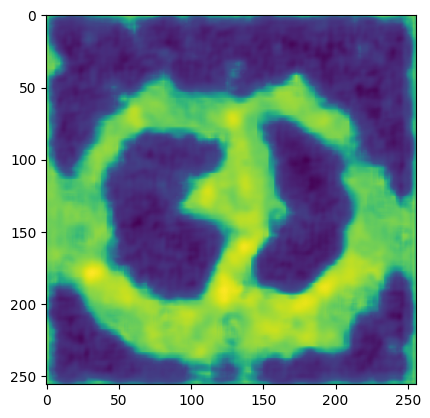

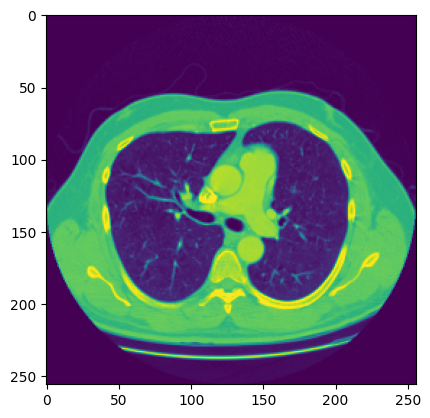

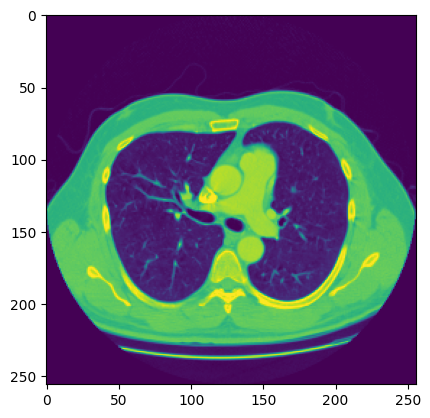

Validation loss: 77769.109375:   0%|          | 0/15 [00:00<?, ?batch/s]


In [20]:
import matplotlib.pyplot as plt

model.eval()

with torch.no_grad():
  with tqdm.tqdm(test_dataloader, unit="batch") as tepoch:
    for batch_idx, (lesion, lesion_free, _) in enumerate(tepoch):
      lesion = lesion.to(device)
      lesion_free = lesion_free.to(device)
      recon, mu, logvar = model(lesion)
      if batch_idx % 10 == 0:
        tepoch.set_description(f"Validation loss: {loss / len(lesion)}")
        recon = recon[0][0].cpu().numpy()
        # The next 3 lines is to make the small value smaller and big value bigger
        # big_scale = 1.01
        # small_scale = 0.99
        # recon = np.where(recon > recon.mean(), recon * big_scale, recon * small_scale)
        print(lesion_free[0][0].cpu().numpy().min(), lesion_free[0][0].cpu().numpy().max())
        print(lesion[0][0].cpu().numpy().min(), lesion[0][0].cpu().numpy().max())
        print(recon.min(), recon.max())
        plt.imshow(recon)
        plt.show()
        plt.imshow(lesion_free[0][0].cpu().numpy())
        plt.show()
        plt.imshow(lesion[0][0].cpu().numpy())
        plt.show()
        break

Validation loss: 77769.109375:   0%|          | 0/15 [00:00<?, ?batch/s]

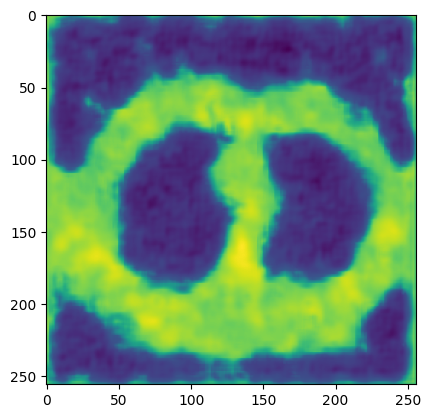

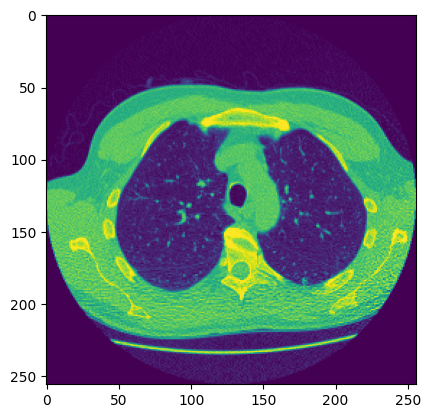

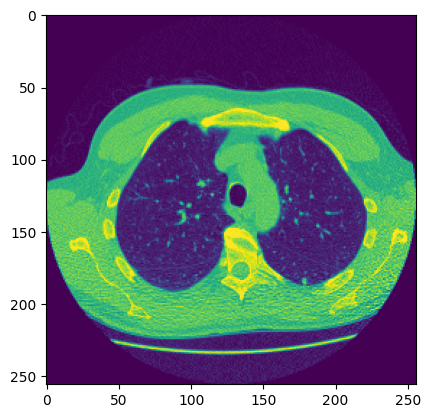

Validation loss: 77769.109375:   0%|          | 0/15 [00:00<?, ?batch/s]


In [18]:
import matplotlib.pyplot as plt

model.eval()

with torch.no_grad():
  with tqdm.tqdm(test_dataloader, unit="batch") as tepoch:
    for batch_idx, (lesion, lesion_free, _) in enumerate(tepoch):
      lesion = lesion.to(device)
      lesion_free = lesion_free.to(device)
      recon, mu, logvar = model(lesion)
      if batch_idx % 10 == 0:
        tepoch.set_description(f"Validation loss: {loss / len(lesion)}")
        plt.imshow(recon[0][0].cpu().numpy())
        plt.show()
        plt.imshow(lesion_free[0][0].cpu().numpy())
        plt.show()
        plt.imshow(lesion[0][0].cpu().numpy())
        plt.show()
        break

## Module 3: Prior UNet